<a href="https://colab.research.google.com/github/nikhilgunti/Deep-Learning/blob/master/Caltech200_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.models import sequential, Model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from skimage.transform import resize, rescale
from keras.applications.vgg16 import  VGG16, preprocess_input
from keras.applications.resnet50 import resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, datasets, models
import time
import copy
import os
import glob
import cv2

Using TensorFlow backend.


In [0]:
import tarfile
data = tarfile.open('/content/drive/My Drive/Spring_2020/NN/Deep Learning/NN_Datasets/caltech_200/images.tgz')
data.extractall(path='/content/drive/My Drive/Spring_2020/NN/Deep Learning/NN_Datasets/caltech_200/Images')

In [0]:
pip install split-folders tqdm

In [0]:
import split_folders
split_folders.ratio('/content/drive/My Drive/Spring_2020/NN/Deep Learning/NN_Datasets/caltech_200/Images/images', 
                    output='/content/drive/My Drive/Spring_2020/NN/Deep Learning/NN_Datasets/caltech_200/Images/images/Output', seed =1876, ratio =(0.8, 0.2))

Copying files: 6033 files [01:25, 70.66 files/s]


In [0]:
train_img_count = sum([len(files) for r , d, files in os.walk('/content/drive/My Drive/Spring_2020/ML_DL_Stuff/Deep Learning/NN_Datasets/caltech_200/Images/Output/train')])
print(train_img_count)
test_img_count = sum([len(files) for r , d, files in os.walk('/content/drive/My Drive/Spring_2020/ML_DL_Stuff/Deep Learning/NN_Datasets/caltech_200/Images/Output/val')])
print(test_img_count)

4744
1289


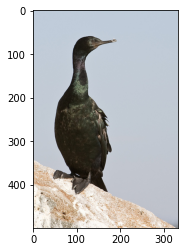

In [0]:
image = cv2.imread('/content/drive/My Drive/Spring_2020/ML_DL_Stuff/Deep Learning/NN_Datasets/caltech_200/Images/Output/train/025.Pelagic_Cormorant/Pelagic_Cormorant_0006_2957118294.jpg')

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)

In [0]:
image.shape

(500, 333, 3)

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = '/content/drive/My Drive/Spring_2020/ML_DL_Stuff/Deep Learning/NN_Datasets/caltech_200/Images/Output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
len(class_names)

200

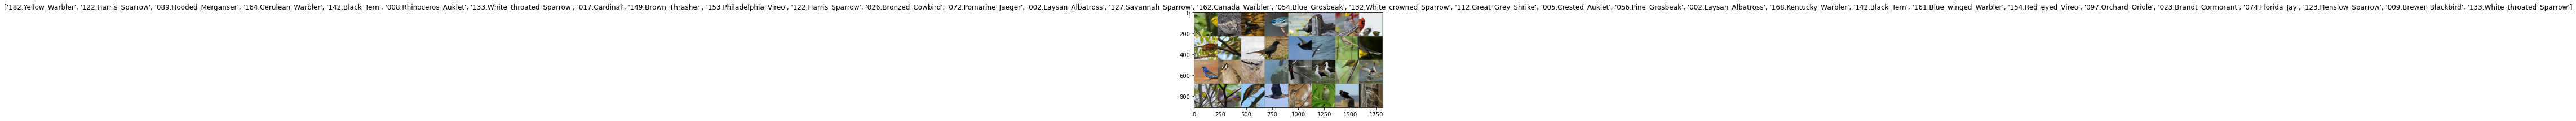

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
model = models.resnet50(pretrained=True)
#print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 5.2319 Acc: 0.0192
val Loss: 5.0115 Acc: 0.0590

Epoch 1/9
----------
train Loss: 4.9376 Acc: 0.0837
val Loss: 4.7276 Acc: 0.1528

Epoch 2/9
----------
train Loss: 4.6543 Acc: 0.1543
val Loss: 4.4439 Acc: 0.2296

Epoch 3/9
----------
train Loss: 4.4219 Acc: 0.2156
val Loss: 4.2146 Acc: 0.2661

Epoch 4/9
----------
train Loss: 4.2001 Acc: 0.2854
val Loss: 4.0024 Acc: 0.2855

Epoch 5/9
----------
train Loss: 4.0086 Acc: 0.3145
val Loss: 3.8098 Acc: 0.3476

Epoch 6/9
----------
train Loss: 3.8233 Acc: 0.3550
val Loss: 3.6303 Acc: 0.3631

Epoch 7/9
----------
train Loss: 3.6783 Acc: 0.4045
val Loss: 3.6076 Acc: 0.3817

Epoch 8/9
----------
train Loss: 3.6596 Acc: 0.4288
val Loss: 3.5890 Acc: 0.3856

Epoch 9/9
----------


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)